# Applied Economic Analysis: Python Assignment

|Name|examnr.|
|----|-------|
|Joost Bouten|132978|
|Twan Vissers|495770|

# Exploring the world of cryptocurrencies

## Question

Out of the ten most valuable cryptocurrencies, which would be the best investment according to the [Sharpe ratio](https://web.stanford.edu/~wfsharpe/art/sr/sr.htm)?


### Motivation

### Method

### Answer

## Assumptions

We evaluate the investment decision problem using 2017 daily closing rates. These data may not at all be a good representation of future periods. The market of cryptocurrencies is subject to great debate and speculation as their true value is still very much unclear.

## Importing libraries and data

In [107]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pandas_datareader.data import DataReader 
from datetime import date
from matplotlib.ticker import FuncFormatter
from bokeh.plotting import figure, ColumnDataSource
from bokeh.io import output_file, show, output_notebook
from bokeh.models import HoverTool
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from datetime import datetime, timedelta

# Hiding annoying warnings
import warnings
warnings.filterwarnings('ignore')

# Setting the plotting style
%matplotlib inline
plt.style.use('seaborn')

# Importing the data
df = pd.read_json("https://api.coinmarketcap.com/v1/ticker/?limit=0")

In [2]:
# Data inspection
df.head(5)

,24h_volume_usd,available_supply,id,last_updated,market_cap_usd,max_supply,name,percent_change_1h,percent_change_24h,percent_change_7d,price_btc,price_usd,rank,symbol,total_supply
0,1.433270e+10,1.681185e+07,bitcoin,1.516352e+09,1.986673e+11,2.100000e+07,Bitcoin,2.43,5.74,-15.07,1.000000,11817.100000,1,BTC,1.681185e+07
1,5.409930e+09,9.707408e+07,ethereum,1.516352e+09,1.037460e+11,NaN,Ethereum,2.72,7.45,-13.19,0.090126,1068.730000,2,ETH,9.707408e+07
2,7.453080e+09,3.873914e+10,ripple,1.516352e+09,6.459946e+10,1.000000e+11,Ripple,4.73,20.25,-19.37,0.000141,1.667550,3,XRP,9.999309e+10
3,1.003470e+09,1.691964e+07,bitcoin-cash,1.516352e+09,3.138525e+10,2.100000e+07,Bitcoin Cash,3.90,5.08,-27.43,0.156429,1854.960000,4,BCH,1.691964e+07
4,8.247320e+08,2.592707e+10,cardano,1.516352e+09,1.732595e+10,4.500000e+10,Cardano,4.44,8.33,-9.40,0.000056,0.668257,5,ADA,3.111248e+10


In [3]:
# Selecting the relevant columns
market_cap = df[['name','market_cap_usd']]

# Dropping currencies without market capitalization
market_cap = market_cap.dropna()
market_cap = market_cap.query('market_cap_usd > 0')

# Setting the index
market_cap.set_index('name', inplace=True)

In [4]:
market_cap.head()

,market_cap_usd
name,
Bitcoin,1.986673e+11
Ethereum,1.037460e+11
Ripple,6.459946e+10
Bitcoin Cash,3.138525e+10
Cardano,1.732595e+10


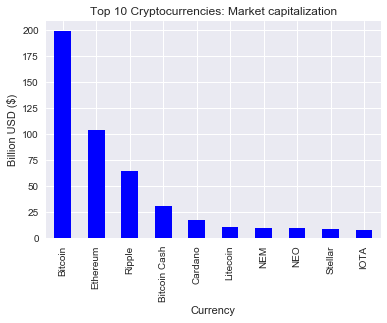

Total market capitalization of cryptocurrencies: $ 588.12 billion


In [5]:
_ = (market_cap[:10]/1000000000).plot.bar(color='blue', legend=False)
_ = plt.title('Top 10 Cryptocurrencies: Market capitalization')
_ = plt.xlabel('Currency')
_ = plt.ylabel('Billion USD ($)')
plt.show()

total_cap = np.sum(market_cap)
print('Total market capitalization of cryptocurrencies: $', round(total_cap[0]/1000000000,2), 'billion')

In [6]:
# Importing the data
df1 = pd.read_csv('crypto-markets.csv')

# Data inspection
df1.head(5)

,slug,symbol,name,date,ranknow,open,high,low,close,volume,market,close_ratio,spread
0,bitcoin,BTC,Bitcoin,2013-04-28,1,135.30,135.98,132.10,134.21,0,1500520000,0.5438,3.88
1,bitcoin,BTC,Bitcoin,2013-04-29,1,134.44,147.49,134.00,144.54,0,1491160000,0.7813,13.49
2,bitcoin,BTC,Bitcoin,2013-04-30,1,144.00,146.93,134.05,139.00,0,1597780000,0.3843,12.88
3,bitcoin,BTC,Bitcoin,2013-05-01,1,139.00,139.89,107.72,116.99,0,1542820000,0.2882,32.17
4,bitcoin,BTC,Bitcoin,2013-05-02,1,116.38,125.60,92.28,105.21,0,1292190000,0.3881,33.32


In [7]:
# Selecting data as of 2017
df1['date'] = pd.to_datetime(df1['date'])
df1 = df1.loc[df1['date'] >= '2017']

# Selecting relevant columns
exchange = df1[['symbol','name','close','date']]

# Selecting relevant currencies
exchange.dropna(inplace = True)

exchangeBTC = exchange.loc[exchange['symbol'] == 'BTC'] 
exchangeETH = exchange.loc[exchange['symbol'] == 'ETH'] 
exchangeRIP = exchange.loc[exchange['symbol'] == 'XRP'] 

exchange = pd.concat([exchangeBTC, exchangeETH, exchangeRIP], ignore_index=True)

# Order by date
exchange.sort_values(['date','symbol'], inplace=True)

# Setting the index
exchange.set_index('date', inplace=True)

In [8]:
# Constructing new columns from the closing prices
exchange['Bitcoin'] = exchange.close[0::3]
exchange['Ethereum'] = exchange.close[1::3]
exchange['Ripple'] = exchange.close[2::3]

# Keeping only the relevant columns and dropping duplicate rows
exchange = exchange[['Bitcoin','Ethereum','Ripple']]
exchange = exchange.loc[::3,:]

# Inspecting the dataframe
exchange.head()

,Bitcoin,Ethereum,Ripple
date,,,
2017-01-01,998.33,8.17,0.006368
2017-01-02,1021.75,8.38,0.006311
2017-01-03,1043.84,9.73,0.006386
2017-01-04,1154.73,11.25,0.006570
2017-01-05,1013.38,10.25,0.006201


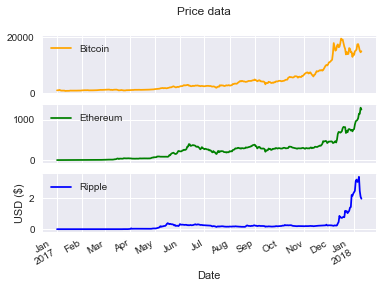

,Bitcoin,Ethereum,Ripple
count,375.000000,375.000000,375.000000
mean,4314.172480,245.937333,0.270975
std,4415.960737,228.729135,0.495798
min,777.760000,8.170000,0.005408
25%,1197.140000,48.260000,0.031331
50%,2608.720000,251.700000,0.197339
75%,4777.005000,317.300000,0.251758
max,19497.400000,1299.740000,3.380000


In [9]:
COLORS = ['orange','green','blue']

_ = exchange.plot.line(title = 'Price data', subplots = True, color=COLORS)
_ = plt.xlabel('Date')
_ = plt.ylabel('USD ($)')
plt.show()

exchange.describe()

In [10]:
# We will compare these returns against the S&P 500
start = date(2017, 1, 1)
end = date(2018, 1, 10)
ticker = '^GSPC'
data_source = 'yahoo'
stock_data = DataReader(ticker, data_source, start, end)

sp500 = pd.DataFrame(stock_data.Close)
sp500.head()

,Close
Date,
2017-01-03,2257.830078
2017-01-04,2270.750000
2017-01-05,2269.000000
2017-01-06,2276.979980
2017-01-09,2268.899902


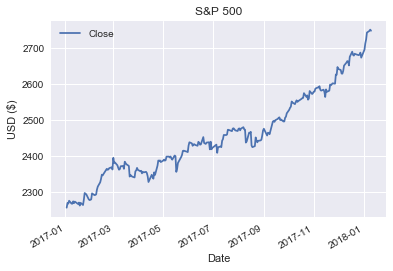

,Close
count,258.000000
mean,2456.749656
std,117.371874
min,2257.830078
25%,2367.520081
50%,2438.255005
75%,2550.312439
max,2751.290039


In [11]:
_ = sp500.plot.line(title='S&P 500')
_ = plt.ylabel('USD ($)')
plt.show()

sp500.describe()

In [12]:
exchange['SP500'] = sp500.Close
exchange.dropna(inplace=True) #to be able to substract SP500 (closed on weekends)
exchange.head()

,Bitcoin,Ethereum,Ripple,SP500
date,,,,
2017-01-03,1043.84,9.73,0.006386,2257.830078
2017-01-04,1154.73,11.25,0.006570,2270.750000
2017-01-05,1013.38,10.25,0.006201,2269.000000
2017-01-06,902.20,10.25,0.006315,2276.979980
2017-01-09,902.83,10.33,0.006167,2268.899902


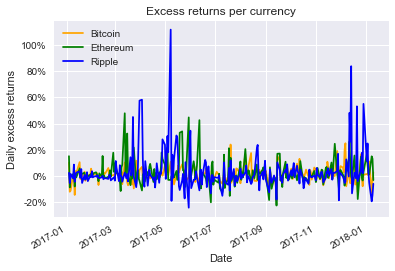

In [13]:
# Showing the daily risk premium of the three different currencies

daily_returns = exchange.pct_change()
crypto_returns = daily_returns[['Bitcoin','Ethereum','Ripple']]
sp_returns = daily_returns['SP500']
excess_returns = crypto_returns.sub(sp_returns, axis=0)

_ = excess_returns.plot(title = 'Excess returns per currency', color=COLORS)
_.yaxis.set_major_formatter(FuncFormatter(lambda y, _:'{:.0%}'.format(y)))
_ = plt.ylabel('Daily excess returns')
_ = plt.xlabel('Date')
plt.show()


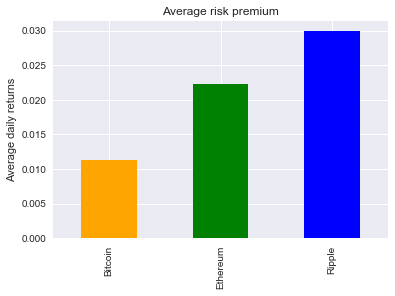

In [14]:
# The mean of the excess returns
avg_excess_returns = excess_returns.mean()

# Plotting the means of the return differences
_ = avg_excess_returns.plot.bar(title = 'Average risk premium', color=COLORS)
_ = plt.ylabel('Average daily returns')
plt.show()


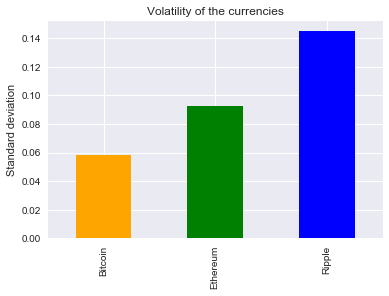

In [15]:
# The standard deviation of the excess returns
std_excess_returns = excess_returns.std()

# Plotting the standard devations of the return differences
_ = std_excess_returns.plot.bar(title = 'Volatility of the currencies', color=COLORS)
_ = plt.ylabel('Standard deviation')
plt.show()

In [16]:
# We define a function for the annualized Sharpe ratio
def sharpe(mean, std, n_periods):
    return np.sqrt(n_periods)*(mean/std)

# Now we calculate the sharpe ratio for the three cryptocurrencies
pd.DataFrame(sharpe(avg_excess_returns, std_excess_returns, len(excess_returns)),columns=["Annualized Sharpe Ratio"])

,Annualized Sharpe Ratio
Bitcoin,3.117520
Ethereum,3.849850
Ripple,3.313994


## Conclusion

In [17]:
print('Based on the Sharpe ratios of these results, it seems best to buy', np.argmax(sharpe(avg_excess_returns, std_excess_returns, len(excess_returns))))

Based on the Sharpe ratios of these results, it seems best to buy Ethereum


## Appendix

In [18]:
rates = df1[['date','name','close']]
rates = rates.pivot_table(index='date',columns='name', values='close', aggfunc='mean')
rates.head()

name,0x,10M Token,1337,2GIVE,300 Token,42-coin,808Coin,8Bit,9COIN,AI Doctor,...,iDice,iEthereum,iExec RLC,iQuant,iTicoin,iXledger,netBit,onG.social,vSlice,vTorrent
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,NaN,NaN,0.000001,0.000330,NaN,NaN,0.000190,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000502,NaN,0.081857,0.025942
2017-01-02,NaN,NaN,0.000002,0.000276,NaN,NaN,0.000163,0.011243,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000451,NaN,0.077368,0.021693
2017-01-03,NaN,NaN,0.000002,0.000380,NaN,NaN,0.000167,0.012373,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000450,NaN,0.062777,0.022364
2017-01-04,NaN,NaN,0.000001,0.000392,NaN,NaN,0.000185,0.013417,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000600,NaN,0.057517,0.025055
2017-01-05,NaN,NaN,0.000001,0.000263,NaN,NaN,0.000101,0.010844,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.055768,0.022355


In [19]:
avg_daily_return = rates.pct_change().mean()
std_daily_return = rates.pct_change().std()

avg_daily_return = pd.DataFrame(avg_daily_return).reset_index()
avg_daily_return.columns = ['name', 'avg']

std_daily_return = pd.DataFrame(std_daily_return).reset_index()
std_daily_return.columns = ['-', 'std']

avg_std_dr = pd.concat([avg_daily_return,std_daily_return], axis=1)
avg_std_dr = avg_std_dr[['name','avg','std']]
avg_std_dr.head()

,name,avg,std
0,0x,0.021216,0.113665
1,10M Token,0.165021,0.729515
2,1337,0.134956,0.742289
3,2GIVE,0.022978,0.155210
4,300 Token,0.021922,0.220645


In [37]:
avg_std_BER = avg_std_dr.loc[(avg_std_dr.name == 'Bitcoin')|(avg_std_dr.name == 'Ethereum')|(avg_std_dr.name == 'Ripple')]
avg_std_BER['colors'] = COLORS
avg_std_BER.head()

,name,avg,std,colors
150,Bitcoin,0.008508,0.050284,orange
461,Ethereum,0.016086,0.073026,green
1031,Ripple,0.022783,0.143775,blue


In [47]:
# Let us make an interactive plot using Bokeh
source = ColumnDataSource(avg_std_dr)
p = figure(y_axis_label='Average daily return', x_axis_label='Std. dev. of daily returns', y_range=(-0.05,0.2), x_range=(0,1), title='avg/std relations for each cryptocurrency')
p.circle(y='avg', x='std', source=source, size=5)

source1 = ColumnDataSource(avg_std_BER)
p.inverted_triangle(y='avg', x='std', source=source1, size=15, fill_color='colors', line_color='black')

hover = HoverTool(tooltips=[('Currency','@name')])
p.add_tools(hover)
show(p)

E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name:  [renderer: GlyphRenderer(id='4514af71-db1d-4df0-858e-199cbcb0d192', ...)]
E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name: color [renderer: GlyphRenderer(id='5d4a5851-9160-427e-bc33-d8c0a946fe50', ...)]
E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name: k [renderer: GlyphRenderer(id='8cb9f354-1a31-4ae8-a34f-20aaf69fd23d', ...)]


slope = 0.13692
intercept = 0.00680


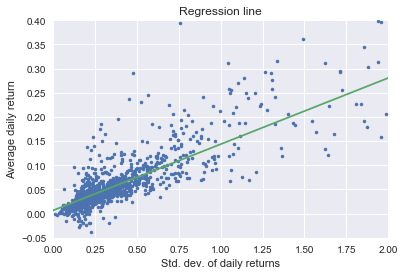

In [49]:
# Getting rid of some outliers
avg_std_dr = avg_std_dr[avg_std_dr['avg']<0.5]
avg_std_dr = avg_std_dr[avg_std_dr['std']<4]

# How is the average related to the standard deviation?
_ = plt.plot(avg_std_dr['std'], avg_std_dr['avg'], marker='.', linestyle='none')
_ = plt.ylim(-0.05,0.4)
_ = plt.xlim(0,2)
_ = plt.ylabel('Average daily return')
_ = plt.xlabel('Std. dev. of daily returns')
_ = plt.title('Regression line')

a, b = np.polyfit(avg_std_dr['std'], avg_std_dr['avg'],1)

print('slope = %.5f'% a)
print('intercept = %.5f'% b)

x = np.array([-1,4])
y = a * x + b

_ = plt.plot(x,y)
plt.show()

http://suruchifialoke.com/2016-08-17-machine-learning-tutorial-with-python-I/

In [266]:
# Let us try to predict Bitcoin prices
bit = df1[df1.symbol == 'BTC'].drop(['ranknow','close_ratio','slug','symbol','name'], axis=1)
bit['HL_PCT'] = 100*(bit.high - bit.low) / bit.low
bit['CO_PCT'] = 100*(bit.close - bit.open) / bit.open
bit = bit.set_index('date')
bit = bit[['close','HL_PCT','CO_PCT','volume']]

# Chosing 20 days as number of forecast days
forecast_out = int(20)
bit['label'] = bit['close'].shift(-forecast_out)

# We now have 20 days of missing labels 
bit.tail()

,close,HL_PCT,CO_PCT,volume,label
date,,,,,
2018-01-06,17527.0,5.653580,0.371662,18314600000,NaN
2018-01-07,16477.6,9.273544,-5.988943,15866000000,NaN
2018-01-08,15170.1,16.396869,-7.927192,18413900000,NaN
2018-01-09,14595.4,7.442457,-3.493193,16660000000,NaN
2018-01-10,14973.3,9.364409,2.637694,18500800000,NaN


In [267]:
# We define a matrix of features
X = np.array(bit.drop(['label'], 1))

# Center to the mean and component wise scale to unit variance
X = preprocessing.scale(X)

# Split the rows for which we do not have label data
X_forecast_out = X[-forecast_out:]
X = X[:-forecast_out]

# Define label vector
y = np.array(bit['label'])
y = y[:-forecast_out]

# Check whether X and y are equal in lenght (if this is not the case we get an error)
assert(len(X)==len(y))

In [268]:
# We split the data into training and test data
# test_size = 0.2 ==> 20% data is test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

# We fit the model to the training data and test it on the test data
clf = LinearRegression()
clf.fit(X_train,y_train)

accuracy = clf.score(X_test, y_test)
print("Accuracy of Linear Regression: ", accuracy)

Accuracy of Linear Regression:  0.8612365975100198


The model did reasonably well in predicting the test data, let us now attempt to predict 30 days into the future  

In [294]:
forecast_prediction = clf.predict(X_forecast_out)

print(forecast_prediction)

last_date = bit.iloc[-1].name

forecast = pd.DataFrame(forecast_prediction)
forecast['date'] = pd.date_range(last_date + timedelta(days=1) , periods=forecast_out, freq='D')
forecast.set_index(['date'], inplace=True)

forecast['BTC Prediction'] = forecast.loc[:,0]
forecast = forecast[['BTC Prediction']]

[10543.30440484 15647.83218291 15287.90559659 15573.79037892
 18055.79731175 17536.23257755 15791.81023892 15084.17541027
 12385.8179462  15413.61621774 15073.71086232 14385.154973
 13661.5384461  11794.92951294 14194.34881268 16435.65822632
 16361.78211563 13437.75990528 12960.65298027 12750.41172112]


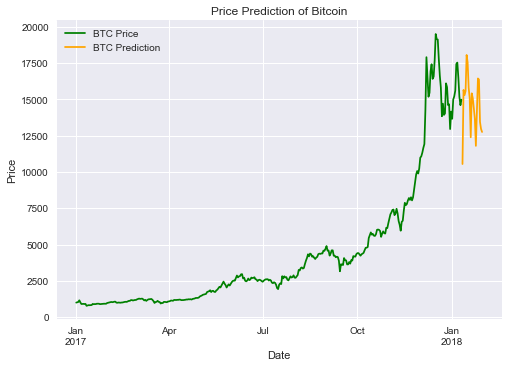

In [295]:
ax = bit['close'].plot(color="green", label='BTC Price')
forecast.plot(color="orange", label='BTC Prediction', ax=ax)
plt.legend()
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Price Prediction of Bitcoin')
plt.show()


Note that this model does not know whether Bitcoin is a bubble, it therefore predicts the future only knowing the past prices and not knowing about anything else. The model will therefore predict the prices of Bitcoin to explode in the future as it did in the past, it is very likely that this is an unrealistic scenario. 

Accuracy of Linear Regression:  0.8486299695051074


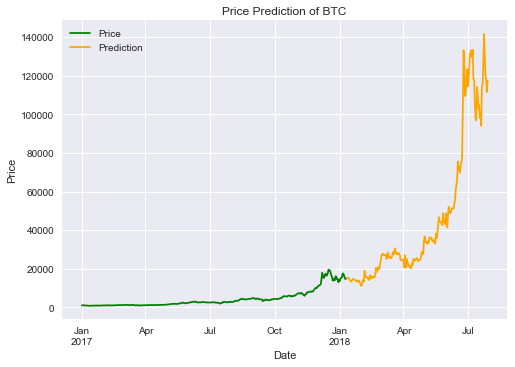

In [306]:
# Let us define a function which outputs the graph shown above for a given number of future periods
def plot_future(n, coin):
    # Let us try to predict Bitcoin prices
    bit = df1[df1.symbol == coin].drop(['ranknow','close_ratio','slug','symbol','name'], axis=1)
    bit['HL_PCT'] = 100*(bit.high - bit.low) / bit.low
    bit['CO_PCT'] = 100*(bit.close - bit.open) / bit.open
    bit = bit.set_index('date')
    bit = bit[['close','HL_PCT','CO_PCT','volume']]
    
    # Chosing n days as number of forecast days
    forecast_out = int(n)
    bit['label'] = bit['close'].shift(-forecast_out)
    
    # We now have n days of missing labels 
    # We define a matrix of features
    X = np.array(bit.drop(['label'], 1))
    
    # Center to the mean and component wise scale to unit variance
    X = preprocessing.scale(X)
    
    # Split the rows for which we do not have label data
    X_forecast_out = X[-forecast_out:]
    X = X[:-forecast_out]
    
    # Define label vector
    y = np.array(bit['label'])
    y = y[:-forecast_out]
    
    # Check whether X and y are equal in lenght (if this is not the case we get an error)
    assert(len(X)==len(y))
    
    # We split the data into training and test data
    # test_size = 0.2 ==> 20% data is test data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
    
    # We fit the model to the training data and test it on the test data
    clf = LinearRegression()
    clf.fit(X_train,y_train)
    
    accuracy = clf.score(X_test, y_test)
    print("Accuracy of Linear Regression: ", accuracy)
    forecast_prediction = clf.predict(X_forecast_out)

    last_date = bit.iloc[-1].name
    
    forecast = pd.DataFrame(forecast_prediction)
    forecast['date'] = pd.date_range(last_date + timedelta(days=1) , periods=forecast_out, freq='D')
    forecast.set_index(['date'], inplace=True)
    
    forecast['Prediction'] = forecast.loc[:,0]
    forecast = forecast[['Prediction']]
    
    ax = bit['close'].plot(color="green", label='Price')
    forecast.plot(color="orange", label='Prediction', ax=ax)
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title('Price Prediction of '+coin)
    plt.show()

# Let us show what the model predicts 200 days into the future
    
plot_future(200, 'BTC')

As can be seen above, the model predicts BTC prices to explode. Let us plot another currency.

Accuracy of Linear Regression:  0.4575297250319439


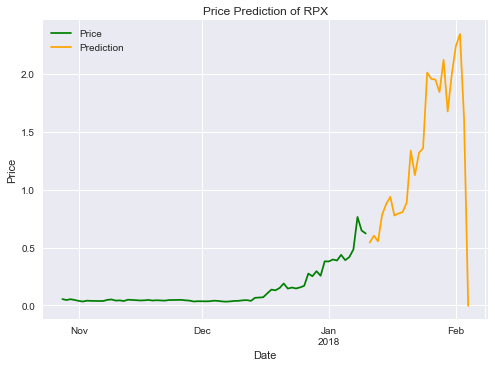

In [315]:
plot_future(25, 'RPX')

Ripple seems to crash at the end of January... (Pretty inaccurate though)